**Dependencies**

In [ ]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(annotatr)
library(GenomicRanges)

In [184]:
#DMRcate DMRs
#severe vs healthy samples DMRcate results
SN_325<-readRDS("results_ranges_SN.rds")
#severe vs mild samples DMRcate results
SM_325<-readRDS("results_ranges.rds")
#mild vs Healthy samples DMRcate results
MN_325<-readRDS("results_ranges_MN.rds")

GRanges object with 2 ranges and 8 metadata columns:
      seqnames            ranges strand |   no.cpgs min_smoothed_fdr
         <Rle>         <IRanges>  <Rle> | <integer>        <numeric>
  [1]     chr6 29854740-29856938      * |        44      1.39106e-73
  [2]     chr6 31695970-31698698      * |        62      1.76047e-71
         Stouffer       HMFDR      Fisher   maxdiff     meandiff
        <numeric>   <numeric>   <numeric> <numeric>    <numeric>
  [1] 2.66387e-54 1.49174e-13 2.59107e-89 -0.106587 -0.000266681
  [2] 3.09805e-46 2.33819e-13 1.09677e-87 -0.107095 -0.004390579
      overlapping.genes
            <character>
  [1]     HLA-H, HCG4P7
  [2]      DDAH2, CLIC1
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

GRanges object with 2 ranges and 8 metadata columns:
      seqnames              ranges strand |   no.cpgs min_smoothed_fdr
         <Rle>           <IRanges>  <Rle> | <integer>        <numeric>
  [1]     chr3 195959232-195959987      * |         4      4.11101e-25
  [2]    chr17   27052676-27054515      * |        17      1.75530e-24
         Stouffer       HMFDR      Fisher    maxdiff    meandiff
        <numeric>   <numeric>   <numeric>  <numeric>   <numeric>
  [1] 2.98459e-14 2.97987e-19 1.36208e-22 -0.0268356 -0.00229087
  [2] 4.65368e-19 3.26787e-13 5.90529e-25 -0.1884343 -0.00761063
           overlapping.genes
                 <character>
  [1]         SLC51A, PCYT1A
  [2] NEK8, AC010761.14, T..
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

**Finding Common genes related to DMRs and meta-analysis DEGs**

In [185]:
upMeta<-read.table("upMeta.txt", header=T)
downMeta<-read.table("downMeta.txt", header=T)
Meta<-rbind(upMeta,downMeta)
SN_df<-data.frame(SN_325)
# Spliting comma-separated genes
DMR_genes <- trimws(unlist(strsplit(as.character(SN_df$overlapping.genes), ",\\s*")))
DMR_genes <- DMR_genes[DMR_genes != ""]  
unique_DMR_genes <- unique(DMR_genes)     # unique genes
deg_genes <- trimws(Meta$GeneSymbol)
unique_deg_genes <- unique(deg_genes)     # unique DEGs
common_genes <- intersect(unique_DMR_genes, unique_deg_genes)
length(unique_DMR_genes)
length(deg_genes)
length(common_genes) 
severityDMR<-read.table("Severity_Genes.txt",header=T)
sevcommon<-intersect(severityDMR$Genes, unique_deg_genes)
length(sevcommon)
head(sevcommon)
#write.table(sevcommon,"Meta_DMR_common.txt",row.names=F, quote=F)

[1] 24616

[1] 845

[1] 744

[1] 195

[1] "GSTM5"   "KAZN"    "RAB13"   "SELP"    "CACNA1E" "RGS16"

In [ ]:
# DMRs with 195 common genes
library(dplyr)
SN_df_subset <- SN_df %>%
  mutate(genes = strsplit(overlapping.genes, ",\\s*")) %>%
  mutate(genes = lapply(genes, trimws)) %>%
  filter(sapply(genes, function(x) any(x %in% sevcommon))) %>%
  select(-genes)

In [182]:
#sorting based on HFDMR
SN_df_subset_sorted <- SN_df_subset[order(SN_df_subset$HMFDR), ]
SN_df_subset_sorted[70,] #example

,seqnames,start,end,width,strand,no.cpgs,min_smoothed_fdr,Stouffer,HMFDR,Fisher,maxdiff,meandiff,overlapping.genes
,<fct>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
203,chr17,73727533,73728061,529,*,5,7.41979e-14,0.0009751976,1.516993e-11,8.402872e-10,-0.0721043,-0.01610515,ITGB4


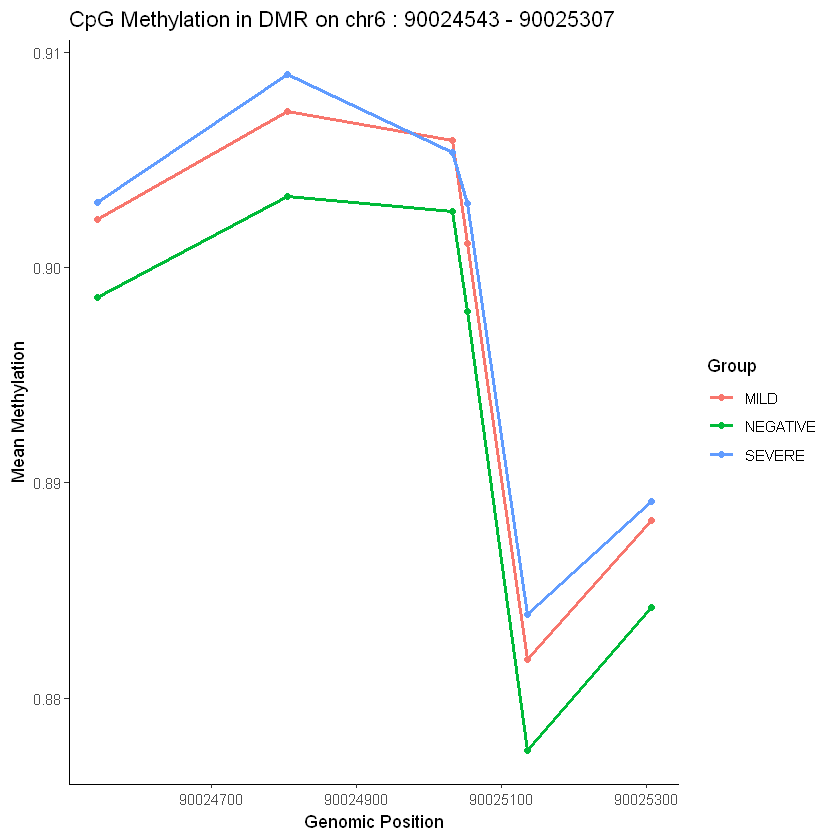

In [203]:
#loading group mean methylation of all cpgs
CpGmean <- fread("CpGmean.csv")

# EPIC annotation.
epi_anno <- getAnnotation(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
epi_anno_df <- as.data.frame(epi_anno)
#  renaming the CpG column to "Name" (to matches with annotation) 
CpGmean_renamed <- CpGmean %>%
  rename(Name = CpG)
CpGmean_annotated <- inner_join(CpGmean_renamed, epi_anno_df[, c("Name", "chr", "pos")], by = "Name")
selected_dmr <- SN_df_subset_sorted[33, ]  #example: selected DMR
dmr_chr   <- as.character(selected_dmr$seqnames)
dmr_start <- selected_dmr$start
dmr_end   <- selected_dmr$end
#  CpGs within the DMR region.
buffer <- 30  
subset_CpGs <- CpGmean_annotated %>%
  filter(chr == dmr_chr,
         pos >= (dmr_start - buffer),
         pos <= (dmr_end + buffer))
if(nrow(subset_CpGs) == 0){  stop("No CpGs found in the selected DMR region.")}

CpG_long <- subset_CpGs %>%
  pivot_longer(
    cols = c("mean_NEGATIVE", "mean_MILD", "mean_SEVERE"),
    names_to = "Group",
    values_to = "MeanMethylation"  )
CpG_long$Group <- gsub("mean_", "", CpG_long$Group)
# plotting
ggplot(CpG_long, aes(x = pos, y = MeanMethylation, color = Group)) +
  geom_line(size = 1) +
  geom_point() +
  labs(
    title = paste("CpG Methylation in DMR on", dmr_chr, ":", dmr_start, "-", dmr_end),
    x = "Genomic Position",
    y = "Mean Methylation",
    color = "Group"
  ) +
  theme_classic()
  #saving plot
output_file <- "DMR_CpG_Methylation.png"
ggsave(output_file, width = 12, height = 4, dpi = 300)

In [197]:
**Annotation**

In [ ]:
#annotation using annotatr
df<-SN_df_subset_sorted[55,c(1,2,3,5,9)]
colnames(df)<-c("chromosome", "st", "en", "rand", "HMFDR")
Grange<-makeGRangesFromDataFrame(df, keep.extra.columns=TRUE, ignore.strand=TRUE, seqinfo=NULL,
                                 seqnames.field="chromosome",
                                 start.field="st", end.field="en" , strand.field="rand", starts.in.df.are.0based=FALSE)
####all possible annotations: 'hg19_cpgs' , 'hg19_basicgenes', 'hg19_genes_intergenic',
##'hg19_enhancers_fantom','hg19_genes_firstexons', 'hg19_genes_intronexonboundaries','hg19_lncrna_gencode'
annots = c('hg19_basicgenes')
#BiocManager::install("TxDb.Hsapiens.UCSC.hg19.knownGene")      #Exposes an annotation databases generated from UCSC by exposing these as TxDb objects
#BiocManager::install("org.Hs.eg.db")                           #Genome wide annotation for Human
annotations = build_annotations(genome = 'hg19', annotations = annots)
dm_annotated = annotate_regions(regions = Grange,  annotations = annotations,  ignore.strand = TRUE,  quiet = FALSE)
df_dm_annotated = data.frame(dm_annotated)  # Coerce to a data.frame
dim(df_dm_annotated)
# Filtering rows where "annot.type" contains the word "promoter"
df_promoter <- df_dm_annotated[grepl("promoter", df_dm_annotated$annot.type), ]

**Finding CpG position in a selected DMR**

In [218]:
#Finding CpG position in a selected DMR to design primers

# selected DMR (row 55 in this case)
selected_dmr <- SN_df_subset_sorted[55, ]
dmr_chr   <- as.character(selected_dmr$seqnames)
dmr_start <- selected_dmr$start
dmr_end   <- selected_dmr$end
# EPIC annot dataframe
epi_anno_df <- as.data.frame(getAnnotation(IlluminaHumanMethylationEPICanno.ilm10b4.hg19))

#  Filtering the annotation to find CpGs within DMR region
cpgs_in_dmr <- epi_anno_df %>%
  filter(chr == dmr_chr,
         pos >= dmr_start,
         pos <= dmr_end)

#  CpG names and positions within the DMR
cpgs_in_dmr[,-c(1:17,20:21,23,36,42:46)]

# Optionally, if you just want a vector of positions:
cpg_positions <- cpgs_in_dmr$pos
print(cpg_positions)
dim(cpgs_in_dmr)

,Islands_Name,Relation_to_Island,UCSC_RefGene_Name,UCSC_RefGene_Group,Phantom4_Enhancers,Phantom5_Enhancers,DMR,X450k_Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,GencodeBasicV12_NAME,GencodeBasicV12_Accession,GencodeBasicV12_Group,GencodeCompV12_NAME,GencodeCompV12_Group,DNase_Hypersensitivity_NAME,DNase_Hypersensitivity_Evidence_Count,OpenChromatin_NAME,OpenChromatin_Evidence_Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
cg14601050,chr17:73726238-73726526,S_Shore,ITGB4;ITGB4;ITGB4,Body;Body;Body,,,,,17:71239030-71239326,,,,,,,,chr17:73727420-73727950,3,,
cg24037380,chr17:73726238-73726526,S_Shore,ITGB4;ITGB4;ITGB4,Body;Body;Body,,,,,17:71239474-71239672,,,ITGB4,ENST00000450894.2,ExonBnd,ITGB4,ExonBnd,chr17:73727420-73727950,3,,
cg26314765,chr17:73726238-73726526,S_Shore,ITGB4;ITGB4;ITGB4,Body;Body;Body,,,,,17:71239474-71239672,,,,,,,,,,chr17:73725998-73728869,6
cg27029445,chr17:73726238-73726526,S_Shore,ITGB4;ITGB4;ITGB4,Body;Body;Body,,,,,17:71239030-71239326,,,,,,,,chr17:73727420-73727950,3,,
cg20942310,chr17:73726238-73726526,S_Shore,ITGB4;ITGB4;ITGB4,Body;Body;Body,,,,,17:71239474-71239672,,,ITGB4,ENST00000450894.2,ExonBnd,ITGB4,ExonBnd,chr17:73728005-73728230,3,,


[1] 73727533 73727879 73727957 73727713 73728061


[1]  5 46

In [ ]:
#downloading DMR sequence to design primers
#chr20: 25387840-25388641 
library(BSgenome.Hsapiens.UCSC.hg19) 
seq <- getSeq(Hsapiens, "chr20", start=25387840, end=25388641)
writeXStringSet(seq, "DMR_chr20.fasta")